In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyplot_themes as themes
from seaborn import palplot # Otherwise all themed plots fail -.-

themes.theme_minimal()

import data_loader
sample = data_loader.get_events_sample(size=30)

from features import vi, spectral

## VI-trajectory

In [2]:
all_component_events = data_loader.get_component_events()
voltage, current, y = data_loader.read_dataset(all_component_events, start_offset=0, duration=4)
voltage, current = data_loader.preprocess(voltage, current, 50)

v,i = vi.vi_trajectory(voltage, current)
vi_trajectory = np.hstack((v,i))

100.0%

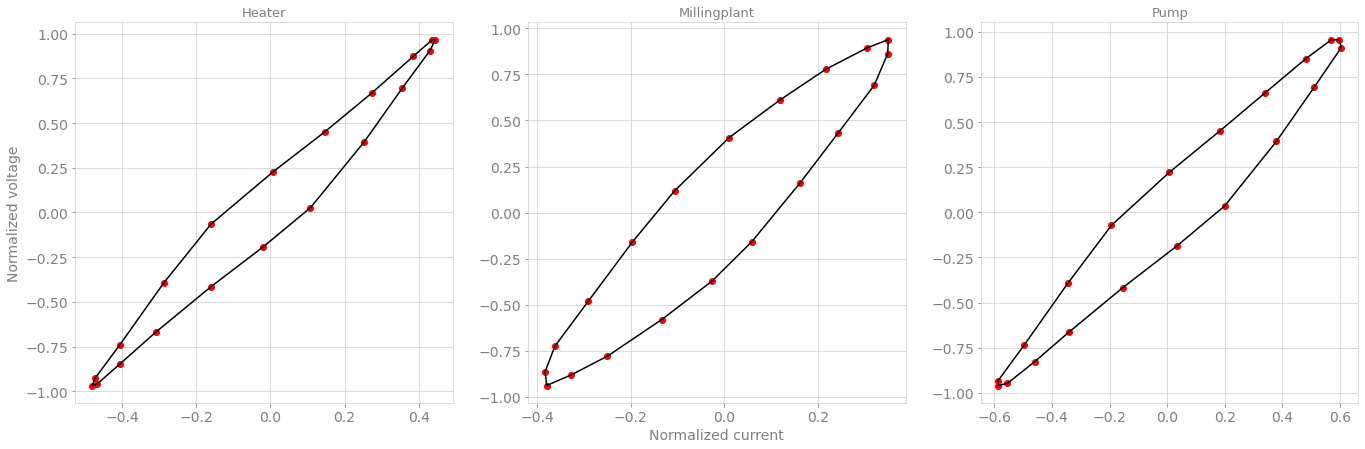

In [3]:
heater = vi_trajectory[y=='heater']
milling = vi_trajectory[y=='millingplant']
pump = vi_trajectory[y=='pump']

# Average over all VI trajectories
heater_v, heater_i = np.mean(heater[:, :20], axis=0), np.mean(heater[:, 20:], axis=0)
milling_v, milling_i = np.mean(milling[:, :20], axis=0), np.mean(milling[:, 20:], axis=0)
pump_v, pump_i = np.mean(pump[:, :20], axis=0), np.mean(pump[:, 20:], axis=0)

fig, axs = plt.subplots(1, 3, figsize=(23, 7))
axs[0].set_title("Heater", fontsize=13)
axs[0].plot(np.append(heater_i, heater_i[0]), np.append(heater_v, heater_v[0]), c='black')
axs[0].scatter(heater_i, heater_v, c='r', alpha=1)
axs[0].set_ylabel("Normalized voltage")
axs[1].set_title("Millingplant", fontsize=13)
axs[1].plot(np.append(milling_i, milling_i[0]), np.append(milling_v, milling_v[0]), c='black')
axs[1].scatter(milling_i, milling_v, c='r', alpha=1)
axs[1].set_xlabel("Normalized current")
axs[2].set_title("Pump", fontsize=13)
axs[2].plot(np.append(pump_i, pump_i[0]), np.append(pump_v, pump_v[0]), c='black')
axs[2].scatter(pump_i, pump_v, c='r', alpha=1)
plt.show()
fig.savefig('../thesis/figures/features_vi_trajectory.pdf', bbox_inches='tight')

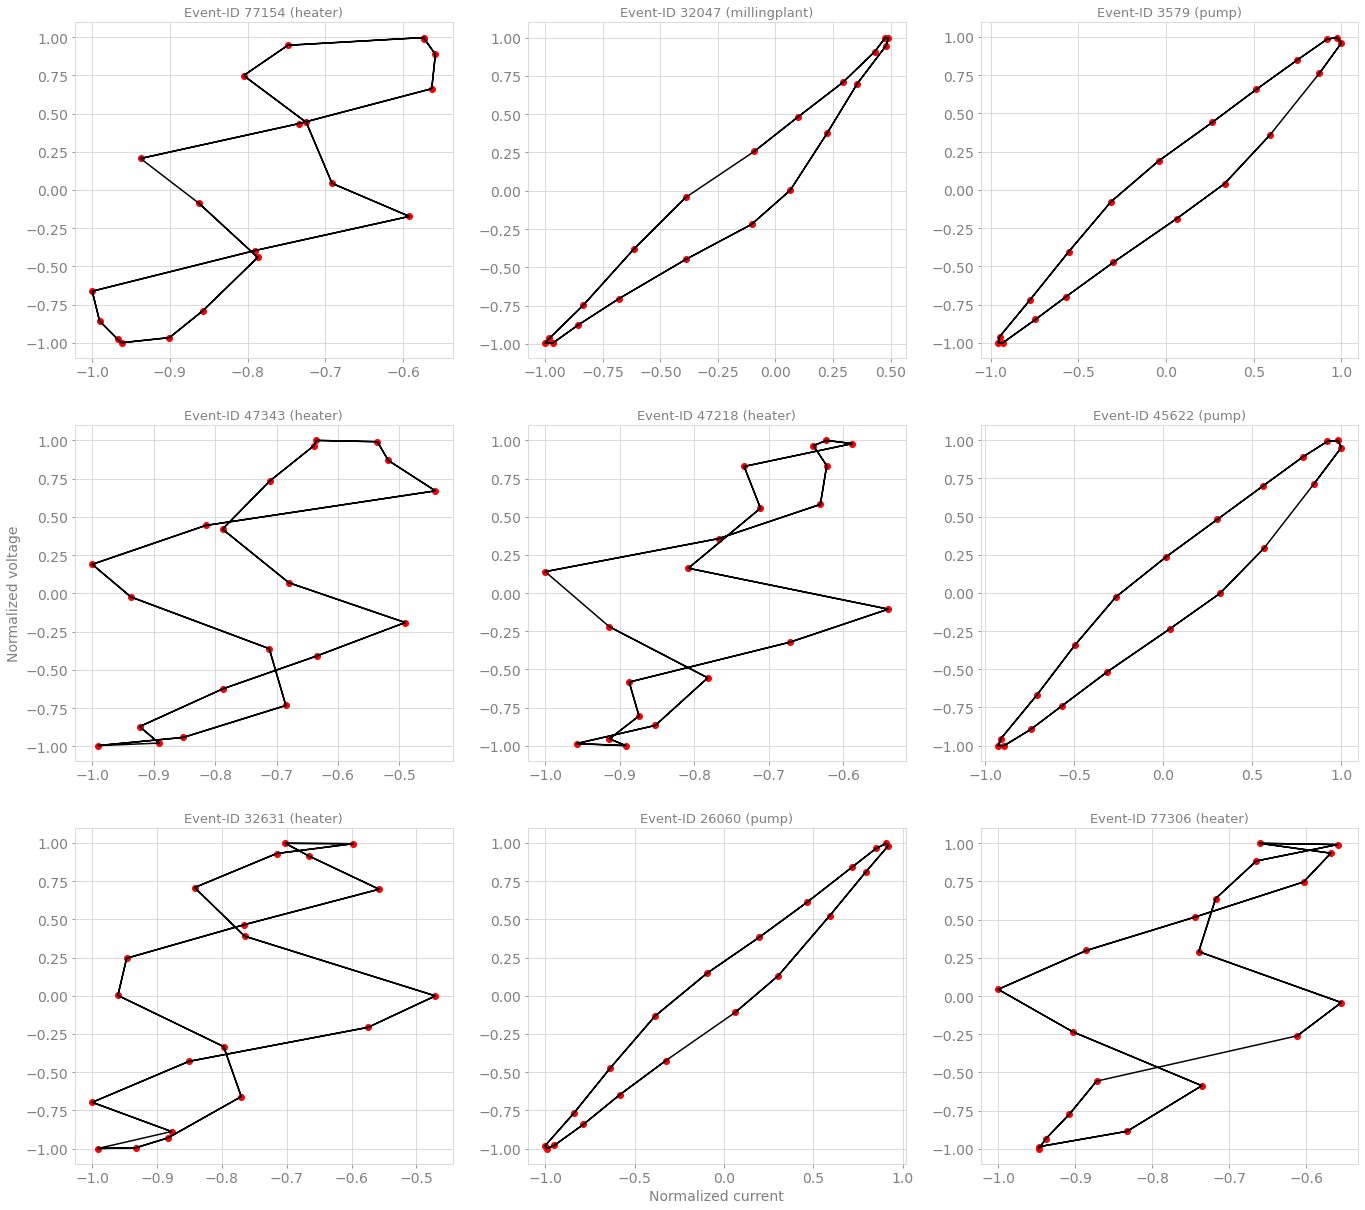

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(23, 21))
for n, (event, (v,i)) in enumerate(sample[:9]):
    v, i = vi.vi_trajectory(v[:6400].reshape(1, -1), i[:6400].reshape(1, -1))
    axs[n // 3, n % 3].set_title(f"Event-ID {event.ID} ({event.Component})", fontsize=13)
    axs[n // 3, n % 3].plot(np.append(i, i[0]), np.append(v, v[0]), c='black')
    axs[n // 3, n % 3].scatter(i, v, c='r', alpha=1)
axs[2, 1].set_xlabel("Normalized current")
axs[1, 0].set_ylabel("Normalized voltage")
plt.show()
fig.savefig('../thesis/figures/features_vi_trajectory.pdf', bbox_inches='tight')

## Waveform approximation

Event ID-77154 (heater)


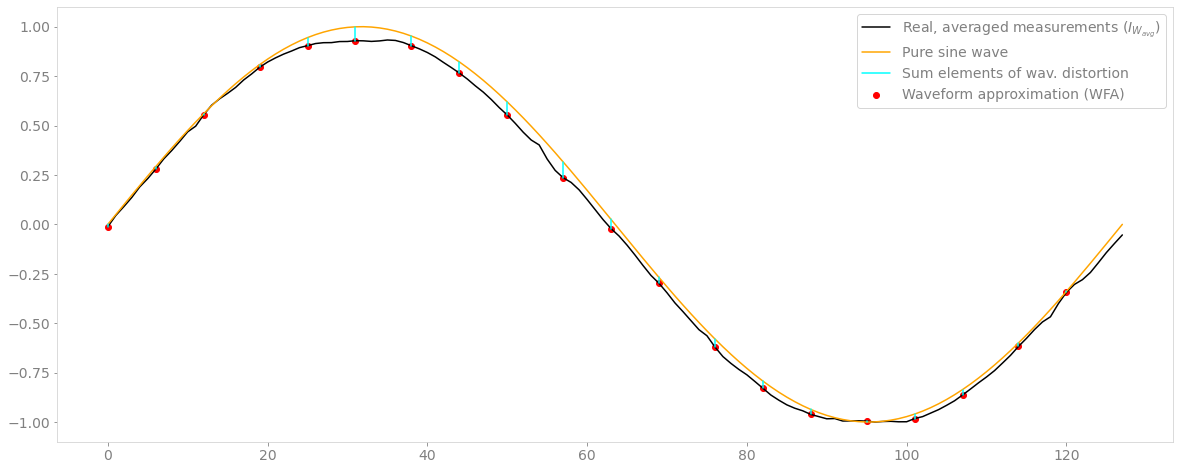

In [5]:
from features.vi import waveform_approximation
from features.helpers import normalize, average_periods

print(f"Event ID-{sample[0][0].ID} ({sample[0][0].Component})")
voltage = sample[0][1][0].reshape(1, -1)
current = sample[0][1][1].reshape(1, -1)
voltage, current = data_loader.preprocess(voltage, current, 50)


sampling_points = np.linspace(0, 127, num=20, endpoint=False, dtype='int')

current = normalize(average_periods(current, 10, 128), method='max')
y = np.sin(np.linspace(0, 2*np.pi, 128))

fig = plt.figure(figsize=(20, 8))
plt.plot(current[0, :], c='black', label='Real, averaged measurements ($I_{W_{avg}}$)')
plt.plot(y, c='orange', label="Pure sine wave")
plt.scatter(sampling_points, current[0, sampling_points], c='red', label="Waveform approximation (WFA)")

h = 0.000001
for point in sampling_points:
    label = "Sum elements of wav. distortion" if point == 0 else None
    plt.plot((point-h, point+h), (current[0, point], y[point]), c='cyan', label=label)

plt.grid()
plt.legend()

plt.show()
fig.savefig('../thesis/figures/features_waveform.pdf', bbox_inches='tight')

## Odd-even ratio

In [6]:
import importlib
importlib.reload(spectral)
from features import spectral

heater


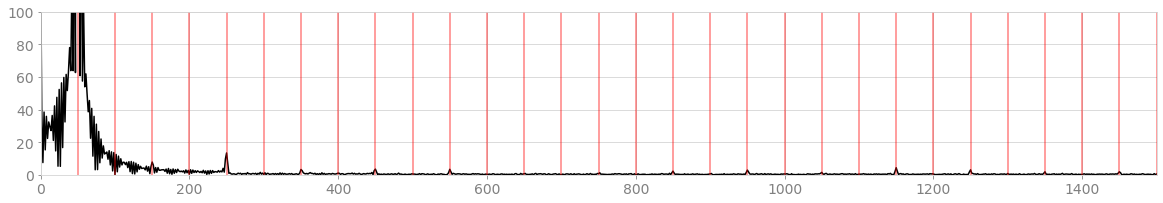

millingplant


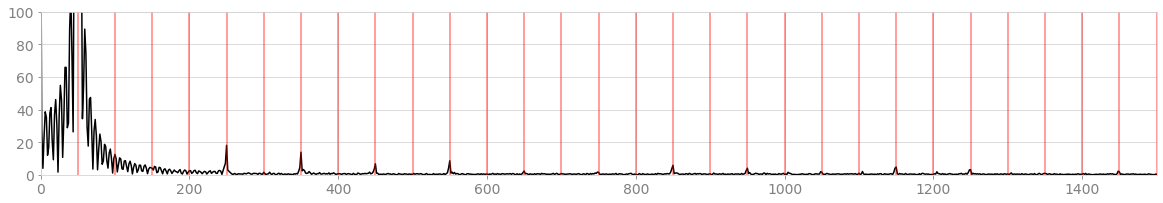

pump


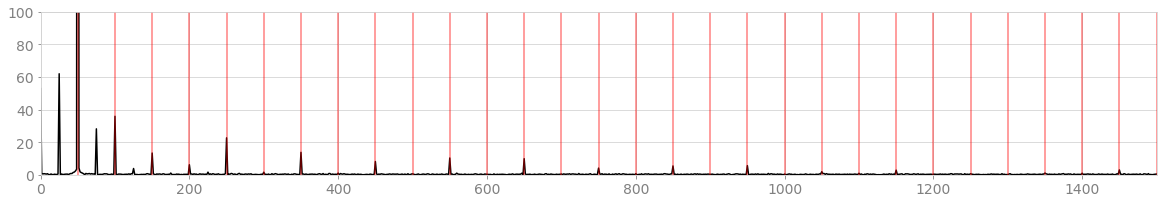

heater


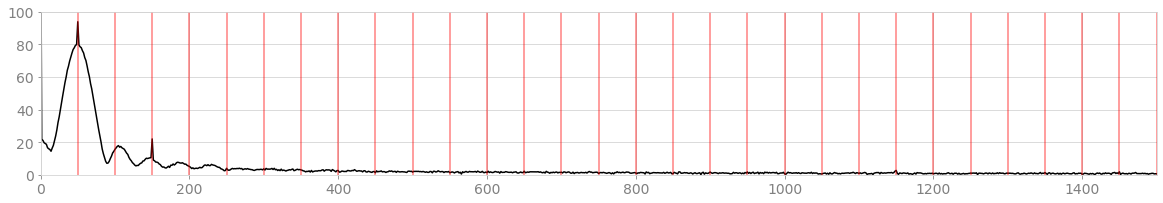

heater


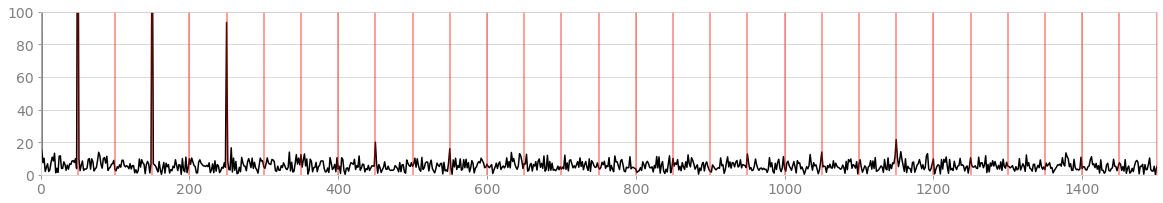

pump


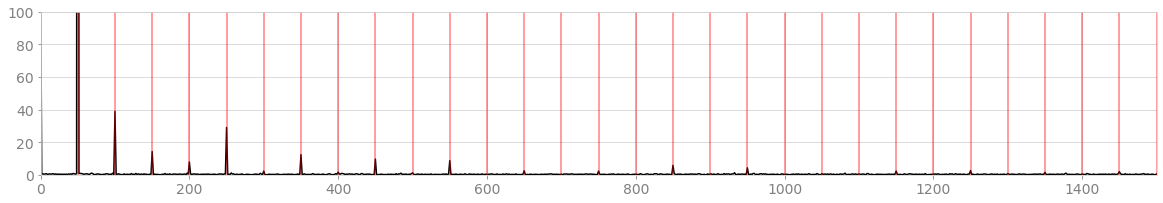

heater


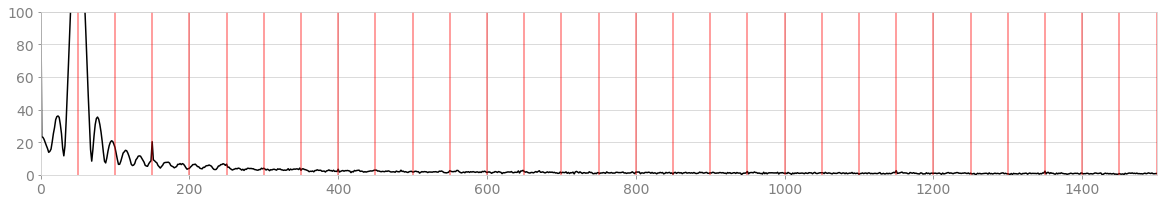

pump


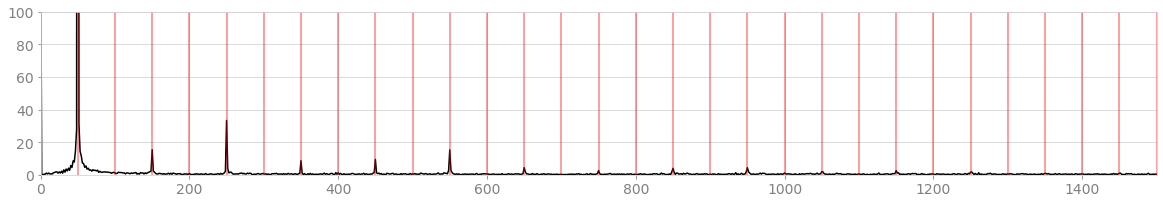

heater


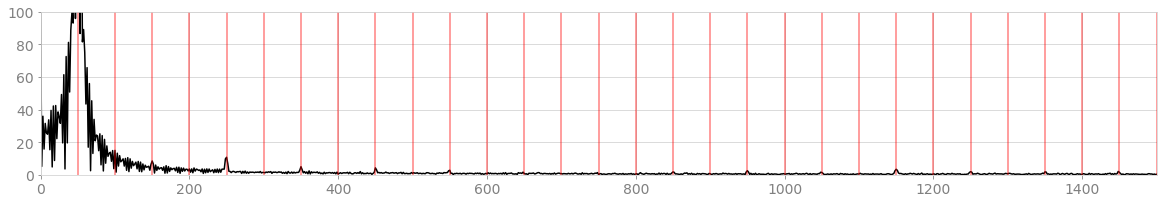

pump


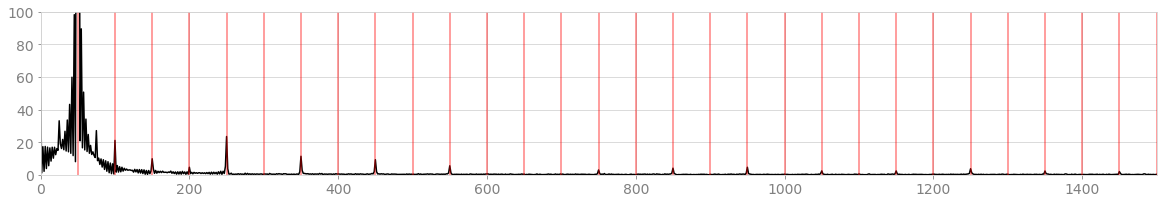

millingplant


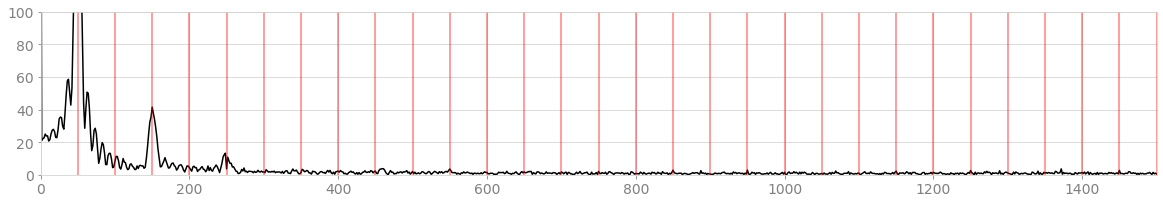

heater


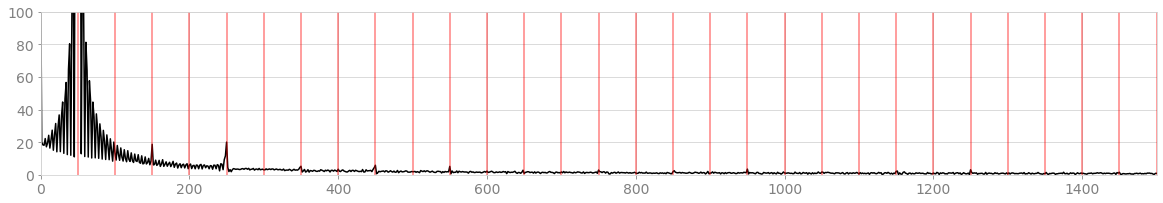

heater


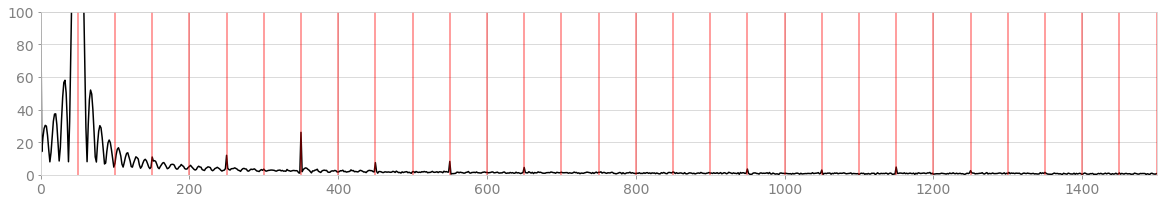

millingplant


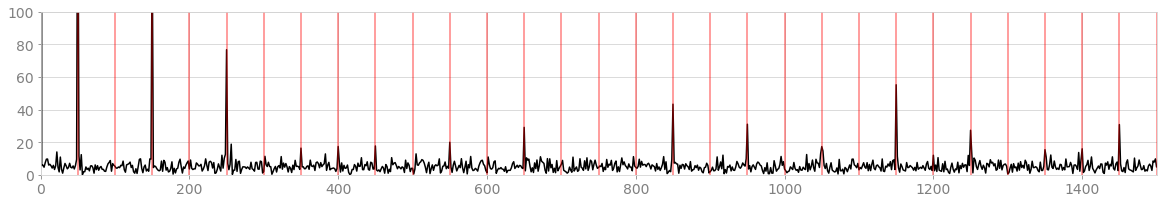

millingplant


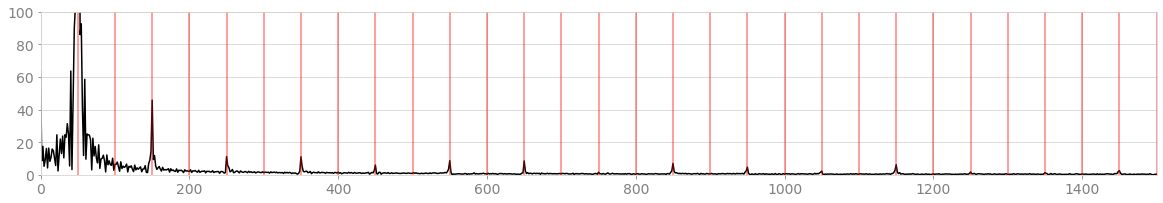

pump


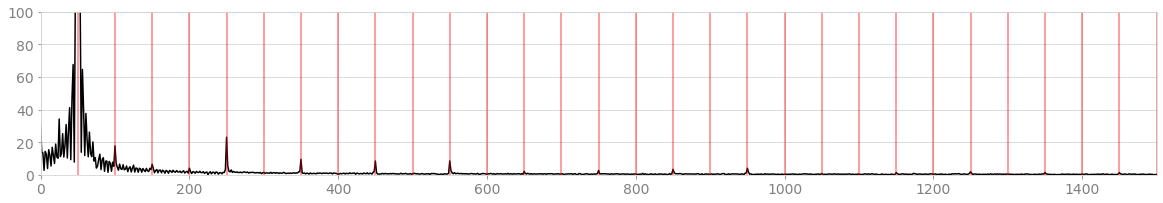

millingplant


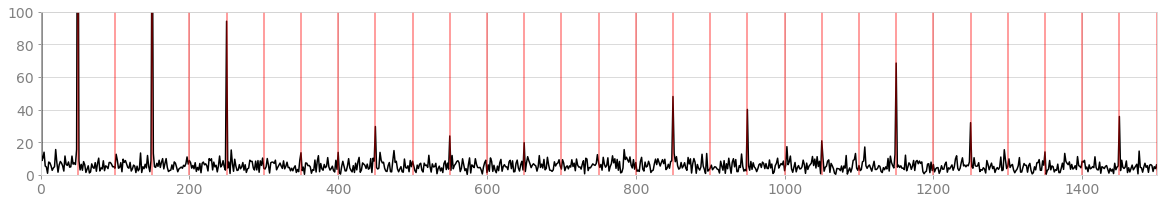

pump


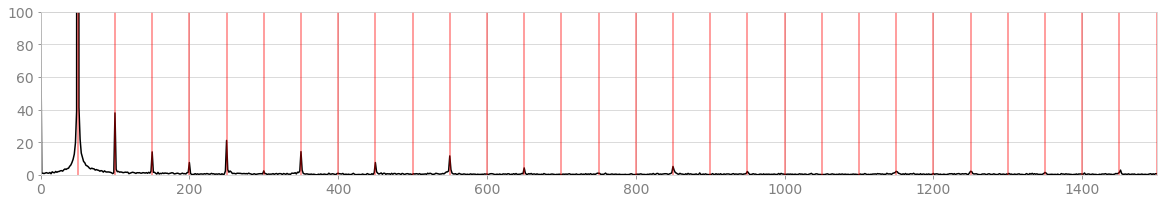

heater


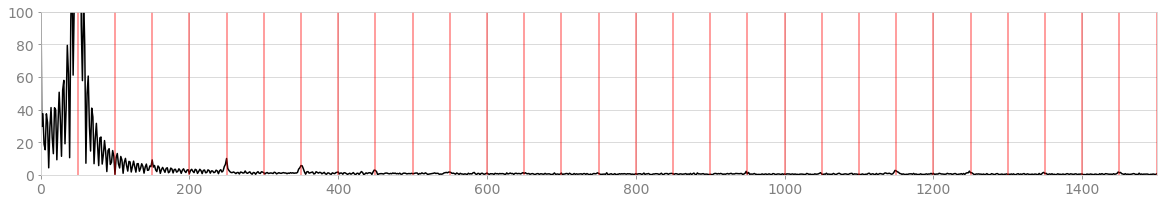

heater


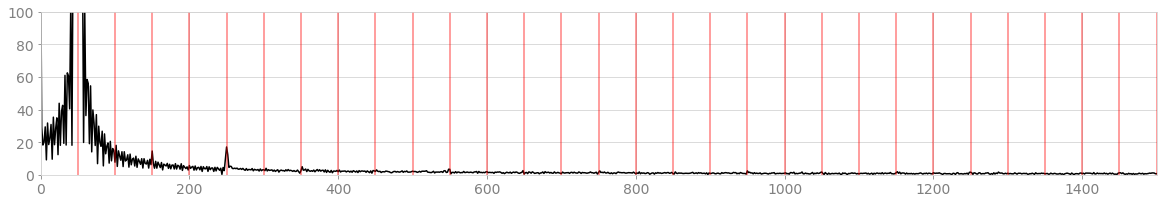

heater


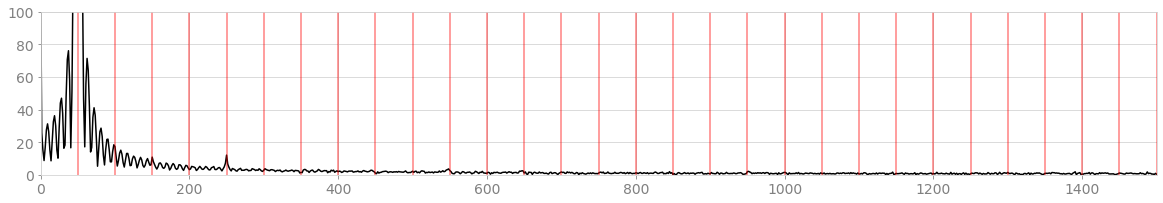

millingplant


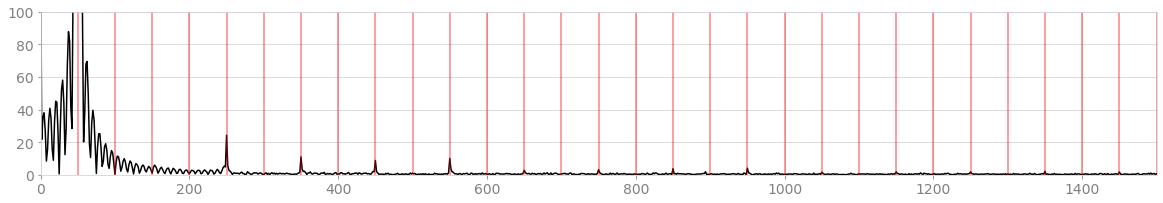

pump


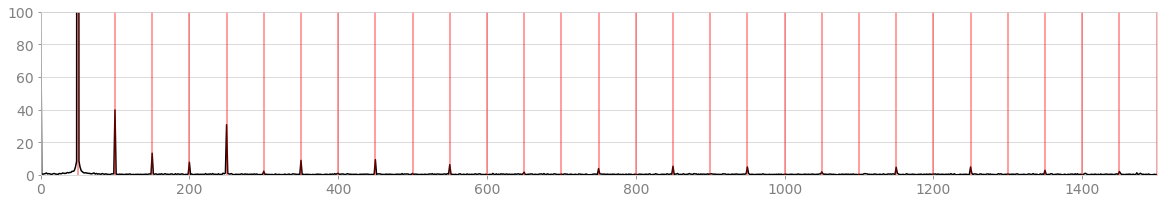

pump


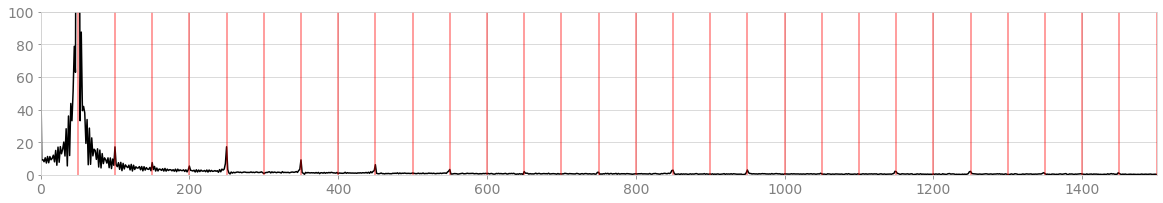

heater


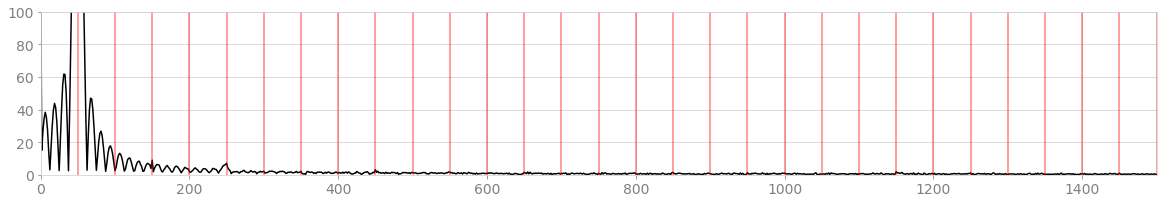

pump


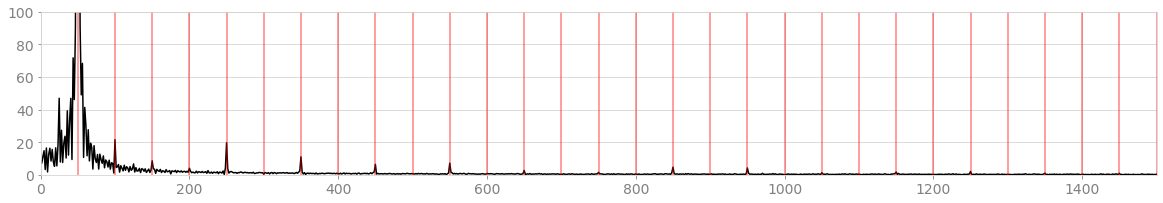

heater


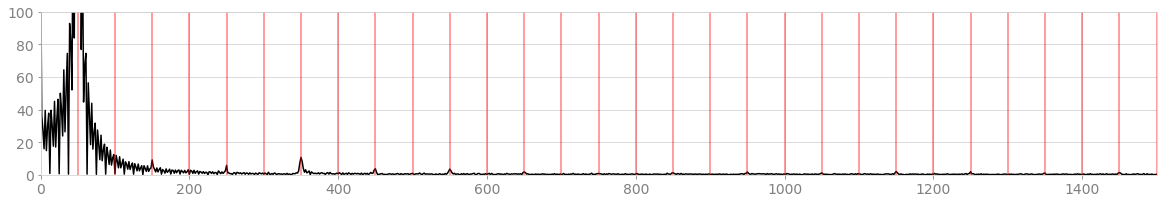

millingplant


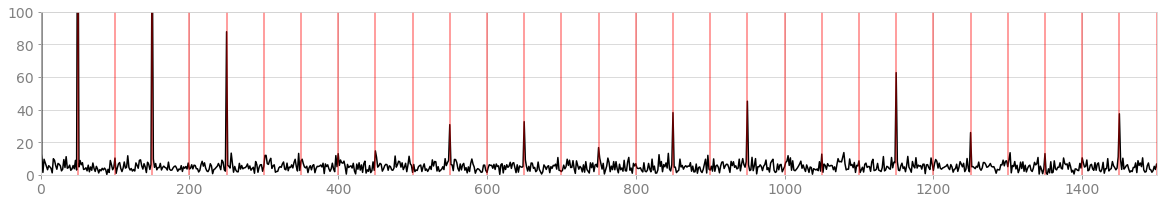

heater


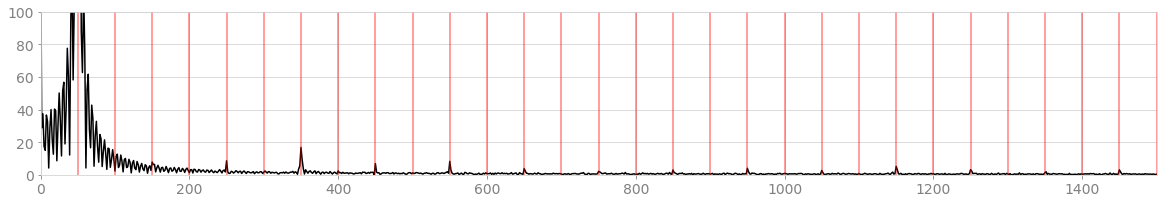

heater


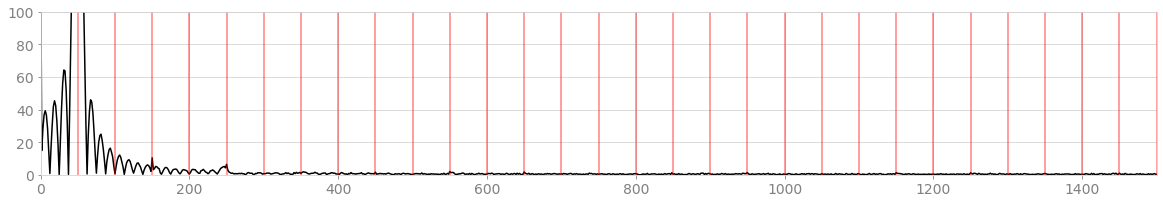

In [7]:
for event, (voltage, current) in sample:
    print(event.Component)
    plt.figure(figsize=(20, 3))
    plt.plot(spectral.spectral_frequencies(4096, limit_to_harmonics=False),
             spectral.spectrum(current[:6400].reshape(1, -1))[0])
    for x in np.arange(50, 1501, 50):
        plt.axvline(x, c='r', alpha=0.5)
    plt.xlim(0, 1500)
    plt.ylim(0, 100)
    plt.show()

## High frequency features

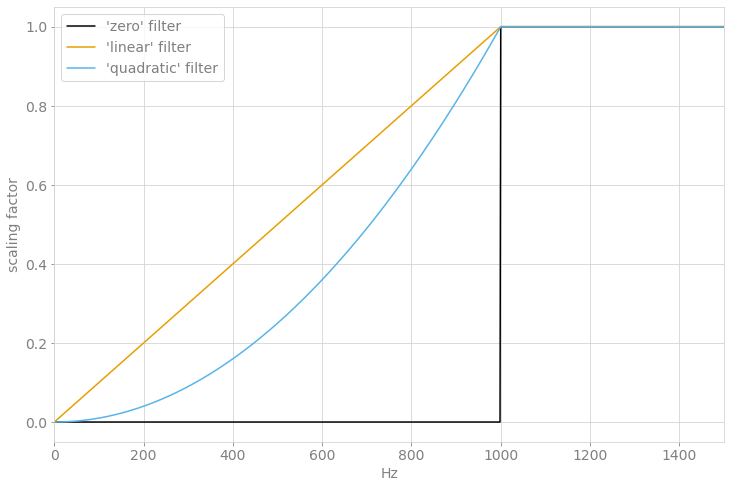

In [8]:
filter_frequency = 1000
freqs = spectral.spectral_frequencies(4096, limit_to_harmonics=False)

# The three filter types as in the features.spectral.high_pass_filter method
zero_filter = np.where(freqs < filter_frequency, 0, 1)
linear_filter = np.where(freqs < filter_frequency, freqs / filter_frequency, 1)
quadratic_filter = np.where(freqs < filter_frequency,
                            np.square(freqs / filter_frequency), 1)

f = plt.figure()
plt.plot(freqs, zero_filter, label="'zero' filter")
plt.plot(freqs, linear_filter, label="'linear' filter")
plt.plot(freqs, quadratic_filter, label="'quadratic' filter")
plt.xlabel('Hz')
plt.ylabel('scaling factor')
plt.legend()
plt.xlim(0, 1500)
plt.show()

f.savefig('../thesis/figures/features_high_pass_filters.pdf', bbox_inches='tight')

# Wavelet transform

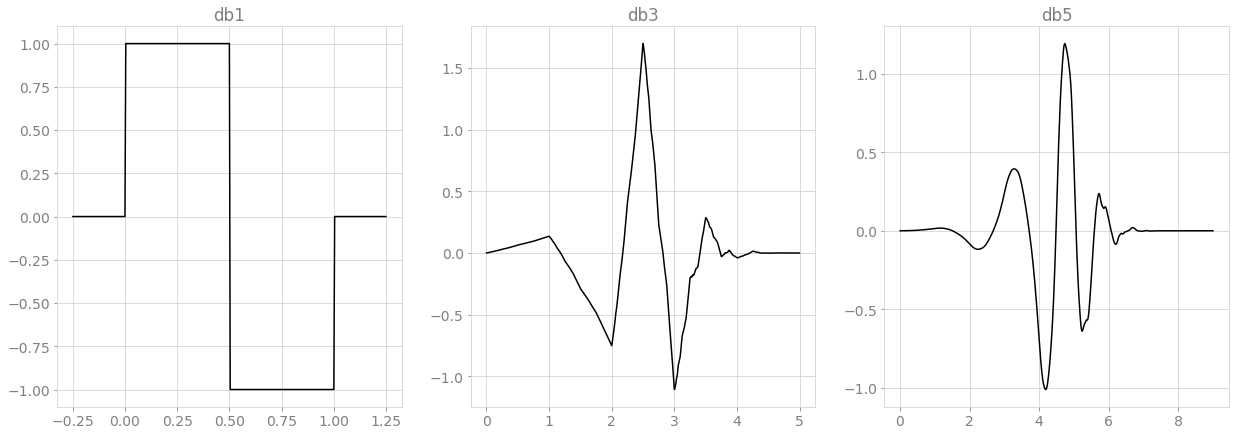

In [9]:
import pywt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))

wavelet = pywt.Wavelet('db1')
_, f, x = wavelet.wavefun()
ax1.plot(np.hstack(([-0.25], x, [1.25])), np.hstack(([0], f, [0])))
ax1.set_title('db1')

wavelet = pywt.Wavelet('db3')
_, f, x = wavelet.wavefun()
ax2.plot(x, f)
ax2.set_title('db3')

wavelet = pywt.Wavelet('db5')
_, f, x = wavelet.wavefun()
ax3.plot(x, f)
ax3.set_title('db5')

plt.show()
fig.savefig('../thesis/figures/features_wavelets.pdf', bbox_inches='tight')

In [10]:
voltage, current, y = data_loader.read_dataset(all_component_events, start_offset=0, duration=4)
voltage, current = data_loader.preprocess(voltage, current, 50)

100.0%

All levels, db1:	Cross-validation F1-score: 0.86
All levels, db2:	Cross-validation F1-score: 0.86
All levels, db3:	Cross-validation F1-score: 0.83
All levels, db4:	Cross-validation F1-score: 0.87
All levels, db5:	Cross-validation F1-score: 0.84
1st level, db1: 	Cross-validation F1-score: 0.84
1st level, db2: 	Cross-validation F1-score: 0.54
1st level, db3: 	Cross-validation F1-score: 0.48
1st level, db4: 	Cross-validation F1-score: 0.46
1st level, db5: 	Cross-validation F1-score: 0.48


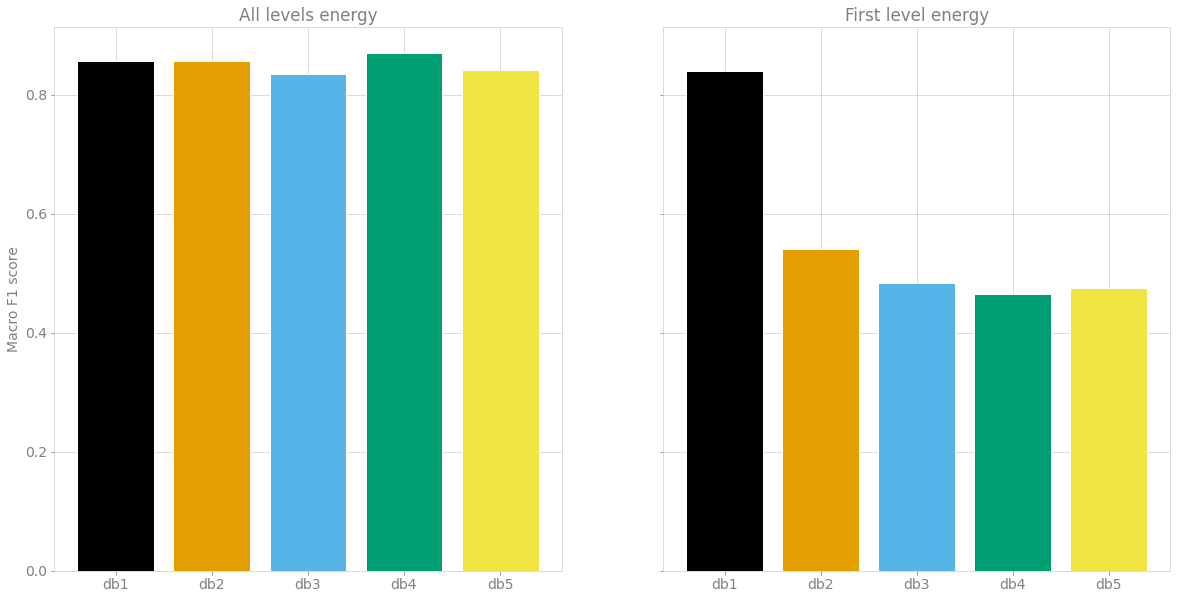

In [11]:
from features.helpers import feature_evaluation
from features.wavelet import all_transform_levels_energy, first_level_energy

wavelets = ['db1', 'db2', 'db3', 'db4', 'db5']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

for i, wavelet in enumerate(wavelets):
    print(f"All levels, {wavelet}:\t", end='')
    score = feature_evaluation(all_transform_levels_energy(current, wavelet=wavelet), y)
    ax1.bar(i, score)
ax1.set_title("All levels energy")
ax1.set_xticks(range(len(wavelets)))
ax1.set_xticklabels(wavelets)
ax1.set_ylabel("Macro F1 score")

for i, wavelet in enumerate(wavelets):
    print(f"1st level, {wavelet}: \t", end='')
    score = feature_evaluation(first_level_energy(current, wavelet=wavelet), y)
    ax2.bar(i, score)
ax2.set_title("First level energy")
ax2.set_xticks(range(len(wavelets)))
ax2.set_xticklabels(wavelets)

plt.show()
fig.savefig('../thesis/figures/features_wavelet_choice.pdf', bbox_inches='tight')